In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import multivariate_normal
import sys, os

sys.path.append(os.getcwd())
np.random.seed(42)

In [2]:
def plot_ellipse(semimaj=1,semimin=1,phi=0,x_cent=0,y_cent=0,theta_num=1e3,ax=None,plot_kwargs=None,\
                    fill=False,fill_kwargs=None,data_out=False,cov=None,mass_level=0.68,colour='b',label=''):

    # Get Ellipse Properties from cov matrix
    if cov is not None:
        eig_vec,eig_val,u = np.linalg.svd(cov)
        # Make sure 0th eigenvector has positive x-coordinate
        if eig_vec[0][0] < 0:
            eig_vec[0] *= -1
        semimaj = np.sqrt(eig_val[0])
        semimin = np.sqrt(eig_val[1])
        if mass_level is None:
            multiplier = np.sqrt(2.279)
        else:
            distances = np.linspace(0,20,20001)
            chi2_cdf = chi2.cdf(distances,df=2)
            multiplier = np.sqrt(distances[np.where(np.abs(chi2_cdf-mass_level)==np.abs(chi2_cdf-mass_level).min())[0][0]])
        semimaj *= multiplier
        semimin *= multiplier
        phi = np.arccos(np.dot(eig_vec[0],np.array([1,0])))
        if eig_vec[0][1] < 0 and phi > 0:
            phi *= -1

    # Generate data for ellipse structure
    theta = np.linspace(0,2*np.pi,int(theta_num))
    r = 1 / np.sqrt((np.cos(theta))**2 + (np.sin(theta))**2)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    data = np.array([x,y])
    S = np.array([[semimaj,0],[0,semimin]])
    R = np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
    T = np.dot(R,S)
    data = np.dot(T,data)
    data[0] += x_cent
    data[1] += y_cent

    # Output data?
    if data_out == True:
        return data

    # Plot!
    return_fig = False
    if ax is None:
        return_fig = True
        fig,ax = plt.subplots()

    if plot_kwargs is None:
        ax.plot(data[0],data[1],color=colour,label=label,linestyle='-')
    else:
        ax.plot(data[0],data[1],color=colour,label=label,**plot_kwargs)

    if fill == True:
        ax.fill(data[0],data[1],**fill_kwargs)

    if return_fig == True:
        return fig
    
def plot_ellipse_cov(cov, cent, ax, colour='b',label=''):
    w,v = np.linalg.eig(cov)
    semi_major_axis_len = 2*np.sqrt(4.6*w[0])
    semi_minor_axis_len = 2*np.sqrt(4.6*w[1])
    theta = np.arctan(v[1,0]/v[0,0])
    plot_ellipse(semi_major_axis_len, semi_minor_axis_len, theta, cent[0], cent[1], ax=ax, colour=colour,label=label)

In [3]:
def weighted_covariance(x, x_mu, tau):
    cov = np.zeros((x.shape[1],x.shape[1]))
    for i in range(x.shape[0]):
        cov += tau[i]*np.outer((x[i,:] - x_mu),(x[i,:] - x_mu))
    cov = cov*1.0/np.sum(tau)
    return cov
    
def compute_log_likelihood(data, alpha_norm, c_n):
    res = np.log(np.sum(alpha_norm[-1,:]))
    res += np.sum(np.log(c_n))
    res /= data.shape[0] # normalization
    return res

def compute_LL(data, mu_list, sigma_list, pi_list):
    ll = 0
    
    pi_1, pi_2, pi_3, pi_4 = pi_list
    mu_1, mu_2, mu_3, mu_4 = mu_list
    sigma_1, sigma_2, sigma_3, sigma_4 = sigma_list
    
    for i in range(data.shape[0]):
        x = pi_1*multivariate_normal.pdf(data[i,:],mean=mu_1,cov=sigma_1) + pi_2*multivariate_normal.pdf(data[i,:],mean=mu_2,cov=sigma_2) + pi_3*multivariate_normal.pdf(data[i,:],mean=mu_3,cov=sigma_3) + pi_4*multivariate_normal.pdf(data[i,:],mean=mu_4,cov=sigma_4)
        ll += np.log(x)
    ll /= data.shape[0]
    
    return ll

In [4]:
def compute_gamma(data, pi_list, mu_list, sigma_list, A):
    
    pi_1, pi_2, pi_3, pi_4 = pi_list
    mu_1, mu_2, mu_3, mu_4 = mu_list
    sigma_1, sigma_2, sigma_3, sigma_4 = sigma_list
    
    alpha_norm = np.zeros((data.shape[0],4))
    c_n = np.zeros((data.shape[0],1))
    
    alpha_1 = np.zeros((1,4))
    alpha_1[0,0] = pi_1*multivariate_normal.pdf(data[0,:],mean=mu_1,cov=sigma_1)
    alpha_1[0,1] = pi_2*multivariate_normal.pdf(data[0,:],mean=mu_2,cov=sigma_2)
    alpha_1[0,2] = pi_3*multivariate_normal.pdf(data[0,:],mean=mu_3,cov=sigma_3)
    alpha_1[0,3] = pi_4*multivariate_normal.pdf(data[0,:],mean=mu_4,cov=sigma_4)
    
    c_n[0,0] = np.sum(alpha_1)
    
    alpha_1_norm = alpha_1/c_n[0,0]
#    print(alpha_1_norm)
    alpha_norm[0,:] = alpha_1_norm # Initialization of alpha
    
    for i in range(1, data.shape[0]):
        o_t = np.zeros((1,4))
        
        o_t[0,0] = multivariate_normal.pdf(data[i,:],mean=mu_1,cov=sigma_1)
        o_t[0,1] = multivariate_normal.pdf(data[i,:],mean=mu_2,cov=sigma_2)
        o_t[0,2] = multivariate_normal.pdf(data[i,:],mean=mu_3,cov=sigma_3)
        o_t[0,3] = multivariate_normal.pdf(data[i,:],mean=mu_4,cov=sigma_4)
        
        alpha = o_t * A.dot(np.transpose(alpha_norm[i-1,:]))
        c_n[i,0] = np.sum(alpha)
        alpha_norm[i,:] = alpha/c_n[i,0]
        
    #***************************************************************
    beta_norm = np.zeros((data.shape[0],4))
    beta_norm[data.shape[0]-1,:] = np.ones((1,4)) # Initialization of beta
    
    for i in range(data.shape[0]-2,-1,-1):
    #    print(i)
        o_t = np.zeros((1,4))
        
        o_t[0,0] = multivariate_normal.pdf(data[i+1,:],mean=mu_1,cov=sigma_1)
        o_t[0,1] = multivariate_normal.pdf(data[i+1,:],mean=mu_2,cov=sigma_2)
        o_t[0,2] = multivariate_normal.pdf(data[i+1,:],mean=mu_3,cov=sigma_3)
        o_t[0,3] = multivariate_normal.pdf(data[i+1,:],mean=mu_4,cov=sigma_4)
        
        beta = A.dot(np.transpose(beta_norm[i+1,:] * o_t))
        beta_norm[i,:] = beta.flatten()/c_n[i+1,0]
    #***************************************************************
    gamma = alpha_norm * beta_norm
    gamma = np.divide(gamma, np.sum(gamma,axis=1).reshape(-1,1))
    
    return gamma, alpha_norm, beta_norm, c_n

In [5]:
train_data = np.loadtxt('hwk3data/hwk3data/EMGaussian.train')
test_data = np.loadtxt('hwk3data/hwk3data/EMGaussian.test')

In [6]:
mu_1 = np.asarray([2.0344, 4.1726])
mu_2 = np.asarray([3.9779, 3.7735])
mu_3 = np.asarray([3.8007, -3.7972])
mu_4 = np.asarray([-3.0620, -3.5345])

sigma_1 = np.asarray([[2.9044, 0.2066],[0.2066, 2.7562]])
sigma_2 = np.asarray([[0.2104, 0.2904],[0.2904, 12.2392]])
sigma_3 = np.asarray([[0.9213, 0.0574],[0.0574, 1.8660]])
sigma_4 = np.asarray([[6.2414, 6.0502],[6.0502, 6.1825]])

A = (1.0/6.0)*np.ones((4,4))
A[0,0] = A[1,1] = A[2,2] =A[3,3] = 0.5

pi_1 = 0.25
pi_2 = 0.25
pi_3 = 0.25
pi_4 = 0.25

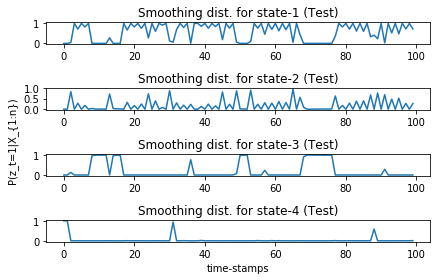

In [7]:
pi_list = [pi_1, pi_2, pi_3, pi_4]
mu_list = [mu_1, mu_2, mu_3, mu_4]
sigma_list = [sigma_1, sigma_2, sigma_3, sigma_4]

gamma, _, _, _ = compute_gamma(test_data, pi_list, mu_list, sigma_list, A)

fig, axes = plt.subplots(4,1)

plt.xlabel('time-stamps')
fig.text(0.00, 0.5, 'P(z_t=1|X_{1:n})', ha='center', va='center', rotation='vertical')
# plt.ylabel('P(z_t=1|X_{1:n})')
    
axes[0].plot(gamma[:100,0])
axes[1].plot(gamma[:100,1])
axes[2].plot(gamma[:100,2])
axes[3].plot(gamma[:100,3])

axes[0].set_title('Smoothing dist. for state-1 (Test)')
axes[1].set_title('Smoothing dist. for state-2 (Test)')
axes[2].set_title('Smoothing dist. for state-3 (Test)')
axes[3].set_title('Smoothing dist. for state-4 (Test)')

plt.tight_layout()
plt.show()

In [8]:
n_iter = 7
data = train_data 

train_ll = []
test_ll = []

for iter_id in range(n_iter):
    print('Iteration: %d' % iter_id)
    #**********************************************************************
    # E step
    #**********************************************************************
    pi_list = [pi_1, pi_2, pi_3, pi_4]
    mu_list = [mu_1, mu_2, mu_3, mu_4]
    sigma_list = [sigma_1, sigma_2, sigma_3, sigma_4]
    
    gamma, alpha_norm, beta_norm, c_n = compute_gamma(data, pi_list, mu_list, sigma_list, A)

    pair_marg = np.zeros((data.shape[0]-1,4,4))
    
    for i in range(1,data.shape[0]):
        for j in range(4): # n-1
            for k in range(4): # n
                if k==0:
                    p_x_given_z = multivariate_normal.pdf(data[i,:],mean=mu_1,cov=sigma_1)
                elif k==1:
                    p_x_given_z = multivariate_normal.pdf(data[i,:],mean=mu_2,cov=sigma_2)
                elif k==2:
                    p_x_given_z = multivariate_normal.pdf(data[i,:],mean=mu_3,cov=sigma_3)
                else:
                    p_x_given_z = multivariate_normal.pdf(data[i,:],mean=mu_4,cov=sigma_4)
                    
                pair_marg[i-1,j,k] = alpha_norm[i-1,j]*beta_norm[i,k]*A[j,k]*p_x_given_z
        pair_marg[i-1,:,:] /= np.sum(pair_marg[i-1,:,:]) 
    
    pi_list = [pi_1, pi_2, pi_3, pi_4]
    mu_list = [mu_1, mu_2, mu_3, mu_4]
    sigma_list = [sigma_1, sigma_2, sigma_3, sigma_4]
    
    ll_train = compute_log_likelihood(train_data, alpha_norm, c_n)
    train_ll.append(ll_train)
    
    
    # fw-bw recursion for test data
    
    pi_list = [pi_1, pi_2, pi_3, pi_4]
    mu_list = [mu_1, mu_2, mu_3, mu_4]
    sigma_list = [sigma_1, sigma_2, sigma_3, sigma_4]
    
    gamma_t, alpha_norm_t, beta_norm_t, c_n_t = compute_gamma(test_data, pi_list, mu_list, sigma_list, A)
    ll_test = compute_log_likelihood(test_data, alpha_norm_t, c_n_t)
    test_ll.append(ll_test)
    
    print('Train log-likelihood = %f, Test log-likelihood = %f' % (ll_train,ll_test))
    
    #**********************************************************************
    # M step
    #**********************************************************************
    mu_1 = np.sum(gamma[:,0].reshape(-1,1)*data,axis=0)/np.sum(gamma[:,0])
    mu_2 = np.sum(gamma[:,1].reshape(-1,1)*data,axis=0)/np.sum(gamma[:,1])
    mu_3 = np.sum(gamma[:,2].reshape(-1,1)*data,axis=0)/np.sum(gamma[:,2])
    mu_4 = np.sum(gamma[:,3].reshape(-1,1)*data,axis=0)/np.sum(gamma[:,3])
    
#    print(mu_1.reshape(-1,1).shape)
#    print(gamma[:,0].shape)
    sigma_1 = weighted_covariance(data,mu_1.reshape(1,-1),gamma[:,0])
    sigma_2 = weighted_covariance(data,mu_2.reshape(1,-1),gamma[:,1])
    sigma_3 = weighted_covariance(data,mu_3.reshape(1,-1),gamma[:,2])
    sigma_4 = weighted_covariance(data,mu_4.reshape(1,-1),gamma[:,3])
    
#    for j in range(4):
#        for k in range(4):
#            A[j,k] = np.sum(pair_marg[:,j,k])/np.sum(pair_marg[:,j,:])
    
    A = np.sum(pair_marg,axis=0)
    for j in range(4):
        Z = np.sum(A[j,:])
        A[j,:] /= Z
    
    pi_1 = gamma[0,0]/np.sum(gamma[0,:])
    pi_2 = gamma[0,1]/np.sum(gamma[0,:])
    pi_3 = gamma[0,2]/np.sum(gamma[0,:])
    pi_4 = gamma[0,3]/np.sum(gamma[0,:])
    


Iteration: 0
Train log-likelihood = -5.143039, Test log-likelihood = -5.512611
Iteration: 1
Train log-likelihood = -4.125968, Test log-likelihood = -4.294893
Iteration: 2
Train log-likelihood = -3.872519, Test log-likelihood = -3.969983
Iteration: 3
Train log-likelihood = -3.840138, Test log-likelihood = -3.905513
Iteration: 4
Train log-likelihood = -3.840012, Test log-likelihood = -3.901166
Iteration: 5
Train log-likelihood = -3.840024, Test log-likelihood = -3.900070
Iteration: 6
Train log-likelihood = -3.839969, Test log-likelihood = -3.899648


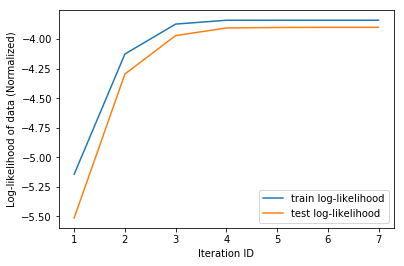

In [9]:
# print(train_ll)
# print(test_ll)
plt.figure()
plt.plot(list(range(1,n_iter+1)),train_ll,label='train log-likelihood')
plt.plot(list(range(1,n_iter+1)),test_ll,label='test log-likelihood')
plt.xlabel('Iteration ID')
plt.ylabel('Log-likelihood of data (Normalized)')
plt.legend()
plt.show()

In [10]:
full_cov_ll = compute_LL(train_data, mu_list, sigma_list, pi_list)
print('Full-covariance GMM Log-Likelihood on train data = %f' % full_cov_ll)

full_cov_ll = compute_LL(test_data, mu_list, sigma_list, pi_list)
print('Full-covariance GMM Log-Likelihood on test data = %f' % full_cov_ll)

Full-covariance GMM Log-Likelihood on train data = -15.498337
Full-covariance GMM Log-Likelihood on test data = -17.418617


In [11]:
def viterbi(data, pi_list, mu_list, sigma_list):
    pi_1, pi_2, pi_3, pi_4 = pi_list
    mu_1, mu_2, mu_3, mu_4 = mu_list
    sigma_1, sigma_2, sigma_3, sigma_4 = sigma_list
    
    T_1 = np.zeros((4, data.shape[0]))
    T_2 = np.zeros((4, data.shape[0]))
    
    T_1[0,0] = pi_1 * multivariate_normal.pdf(data[0,:],mean=mu_1,cov=sigma_1)
    T_1[1,0] = pi_2 * multivariate_normal.pdf(data[0,:],mean=mu_2,cov=sigma_2)
    T_1[2,0] = pi_3 * multivariate_normal.pdf(data[0,:],mean=mu_3,cov=sigma_3)
    T_1[3,0] = pi_4 * multivariate_normal.pdf(data[0,:],mean=mu_4,cov=sigma_4)
    
    for i in range(1,data.shape[0]):
        for j in range(4):
            T_1[j,i] = np.amax([T_1[k,i-1]*A[k,j]*gamma[i,j] for k in range(4)])
            T_2[j,i] = np.argmax([T_1[k,i-1]*A[k,j]*gamma[i,j] for k in range(4)])
            
    ml_states = np.zeros((data.shape[0],1),dtype='int')
    
    ml_states[-1,0] = np.argmax(T_1[:,-1])
    last_state = ml_states[-1,0]
    
    for i in range(data.shape[0]-1,0,-1):
        ml_states[i-1,0] = T_2[last_state, i]
        last_state = ml_states[i-1,0]
    
    return ml_states

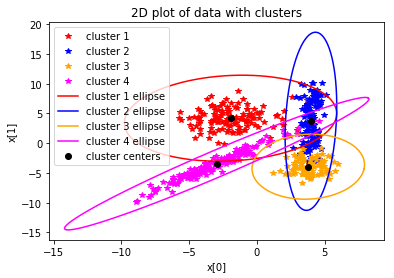

In [12]:
pi_list = [pi_1, pi_2, pi_3, pi_4]
mu_list = [mu_1, mu_2, mu_3, mu_4]
sigma_list = [sigma_1, sigma_2, sigma_3, sigma_4]
    
ml_states = viterbi(train_data, pi_list, mu_list, sigma_list)

cluster_1 = np.asarray([data[j,:] for j in range(data.shape[0]) if ml_states[j,0]==0]).reshape(-1,2)
cluster_2 = np.asarray([data[j,:] for j in range(data.shape[0]) if ml_states[j,0]==1]).reshape(-1,2)
cluster_3 = np.asarray([data[j,:] for j in range(data.shape[0]) if ml_states[j,0]==2]).reshape(-1,2)
cluster_4 = np.asarray([data[j,:] for j in range(data.shape[0]) if ml_states[j,0]==3]).reshape(-1,2)

plt.figure()
plt.plot(cluster_1[:,0], cluster_1[:,1], '*', c='red',label='cluster 1')
plt.plot(cluster_2[:,0], cluster_2[:,1], '*', c='blue',label='cluster 2')
plt.plot(cluster_3[:,0], cluster_3[:,1], '*', c='orange',label='cluster 3')
plt.plot(cluster_4[:,0], cluster_4[:,1], '*', c='magenta',label='cluster 4')

plot_ellipse_cov(sigma_1,mu_1, ax=plt, colour='red',label='cluster 1 ellipse')
plot_ellipse_cov(sigma_2,mu_2, ax=plt, colour='blue',label='cluster 2 ellipse')
plot_ellipse_cov(sigma_3,mu_3, ax=plt, colour='orange',label='cluster 3 ellipse')
plot_ellipse_cov(sigma_4,mu_4, ax=plt, colour='magenta',label='cluster 4 ellipse')

plt.plot(mu_1[0], mu_1[1], 'o', c='black', label='cluster centers')
plt.plot(mu_2[0], mu_2[1], 'o', c='black')
plt.plot(mu_3[0], mu_3[1], 'o', c='black')
plt.plot(mu_4[0], mu_4[1], 'o', c='black')
plt.title('2D plot of data with clusters')
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.legend()
plt.show()

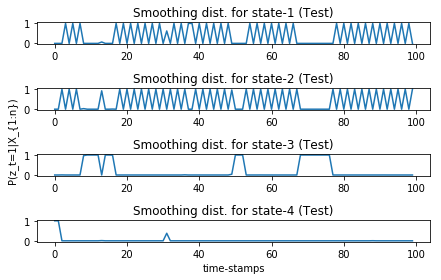

In [13]:
pi_list = [pi_1, pi_2, pi_3, pi_4]
mu_list = [mu_1, mu_2, mu_3, mu_4]
sigma_list = [sigma_1, sigma_2, sigma_3, sigma_4]

gamma,_,_,_ = compute_gamma(test_data, pi_list, mu_list, sigma_list, A)

fig, axes = plt.subplots(4,1)

plt.xlabel('time-stamps')
fig.text(0.00, 0.5, 'P(z_t=1|X_{1:n})', ha='center', va='center', rotation='vertical')
# plt.ylabel('P(z_t=1|X_{1:n})')
    
axes[0].plot(gamma[:100,0])
axes[1].plot(gamma[:100,1])
axes[2].plot(gamma[:100,2])
axes[3].plot(gamma[:100,3])

axes[0].set_title('Smoothing dist. for state-1 (Test)')
axes[1].set_title('Smoothing dist. for state-2 (Test)')
axes[2].set_title('Smoothing dist. for state-3 (Test)')
axes[3].set_title('Smoothing dist. for state-4 (Test)')

plt.tight_layout()
plt.show()

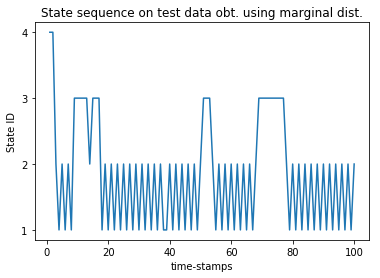

In [14]:
ml_states_test = np.argmax(gamma[:100], axis=1).reshape(-1,1) + 1

plt.figure()
plt.plot(list(range(1,101)),ml_states_test.flatten().tolist())
plt.xlabel('time-stamps')
plt.ylabel('State ID')
plt.yticks([1,2,3,4])
plt.title('State sequence on test data obt. using marginal dist.')
plt.show()

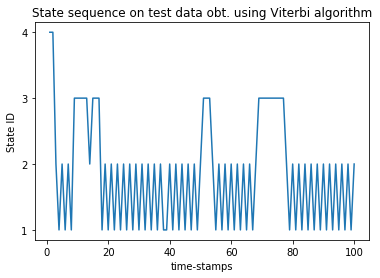

In [15]:
ml_states_test_viterbi = viterbi(test_data, pi_list, mu_list, sigma_list) + 1
ml_states_test_viterbi = ml_states_test_viterbi[:100]

plt.figure()
plt.plot(list(range(1,101)),ml_states_test_viterbi.flatten().tolist())
plt.xlabel('time-stamps')
plt.ylabel('State ID')
plt.yticks([1,2,3,4])
plt.title('State sequence on test data obt. using Viterbi algorithm')
plt.show()